# Homework #4

Build a model to predict flight delays using the Flight Delay dataset here.

It's also the data directory.

Use this blog article as a resource if needed. The blog uses R, but the ideas and process are the same.

It also has a nice discussion of some more tools to evaluate a Classification Model (e.g. confusion matricies, ROC analysis) that we will explore in more detail next time.

HW shows up in Lesson 6, model-validation. You can also look at Lesson 7, classification-evaluation.

# Overall Notes
- I didn't like the blog post a lot. I fit the model explained in the blog post using statsmodels and it didn't converge because of the feature making DEP_TIME (departure time) into 24 categorical features, of which some had no observations. You cannot estimate a coefficient in the model when you have no observations with that value. Even though the model fitted in the blog didn't converge in statsmodels, it DID fit coefficients in scikit-learn. Overall I wouldn't be very confident in those coefficients and thus the model predictions. In the blog post, you can see that the std errors are really high for some of those coefficients.
- Confusion about dummy variables. So sci-kit learn is weird in that it doesn't do this for you. You have to set up the categorical variables yourself, and that means one is left out as the baseline category. If you leave it out, you are 1) predicting one more coefficient than is necessary and 2) making your coefficients not easily interpretable. Instead of creating my own dummy variables manually, I used patsy, which helps you do that.
- Confusion about the effect sizes. So some of the coefficients may be higher because of the units that were used. For example, if you had meters per hr vs. km per hour then the effect size would be much smaller (1 m per hr inc results in a .001 m increase in stopping dist wheres a 1 km per hr increase results in a like 1 m increase in stopping dist). You can look @ p-values if you want to see the most significant vars. Or look at important features through a tree based model.
-  Good job with evaluating models based on R squared. What about AUC with ROC curves since this is a 0,1 outcome problem? Also, some people created a confusion matrix that predicted few (close to 0) delays and called it a good model. Note that the confusion matrix has a default threshold of 0.5 to determine predicting yes or no, and you can change that threshold to get more delay predictions.
- Good EDA! Lots of great graphs :)
- Many of you did a good job using test and training sets.


In [27]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, cross_validation
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import math

# Cool! A way to ignore pink warnings. Thanks to Jackie!
import warnings
warnings.filterwarnings('ignore')

# Import data

In [3]:
flights = pd.read_excel("/Users/mtlee/Code/DAT-ATX-1/data/FlightDelays.xls")

In [4]:
flights.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status,Unnamed: 13,Unnamed: 14
0,1455,OH,1455,JFK,184,2004-01-01,5935,BWI,0,4,1,N940CA,ontime,NaN,NaN
1,1640,DH,1640,JFK,213,2004-01-01,6155,DCA,0,4,1,N405FJ,ontime,All flights out of 3 DC airports (WAS),NaN
2,1245,DH,1245,LGA,229,2004-01-01,7208,IAD,0,4,1,N695BR,ontime,into 3 NYC airports,NaN
3,1715,DH,1709,LGA,229,2004-01-01,7215,IAD,0,4,1,N662BR,ontime,not cancelled,NaN
4,1039,DH,1035,LGA,229,2004-01-01,7792,IAD,0,4,1,N698BR,ontime,flights in January 2004,NaN


In [5]:
print flights.columns.tolist()

[u'CRS_DEP_TIME', u'CARRIER', u'DEP_TIME', u'DEST', u'DISTANCE', u'FL_DATE', u'FL_NUM', u'ORIGIN', u'Weather', u'DAY_WEEK', u'DAY_OF_MONTH', u'TAIL_NUM', u'Flight Status', 'Unnamed: 13', 'Unnamed: 14']


Here's a data dictionary: (from Ian)

|Column   |Definition   |
|---|---|
| CRS_DEP_TIME | Scheduled departure time |
| CARRIER | The airline |
| DEP_TIME | Actual departure time |
| DEST | Destination airport in New York |
| DISTANCE | Flight distance in miles |
| FL_DATE | Flight date |
| FL_NUM | Flight number |
| ORIGIN | Origin airport in Washington D.C. |
| Weather | Was the weather inclement or not? |
| DAY_WEEK | Day of week; 1=Mon … 7=Sun |
| DAY_OF_MONTH | Day of month |
| TAIL_NUM | Airplane identifier |
| Flight Status | Whether the flight was delayed or ontime |

|Code   |Airline   |
|---|---|
| AA | American Airlines, Inc. |
| CO | Continental Air Lines, Inc. |
| DH | Atlantic Coast Airlines |
| DL | Delta Air Lines, Inc. |
| EV | Atlantic Southeast Airlines |
| FL | Airtran Airways Corporation |
| MQ | American Eagle Airlines,inc |
| OH | Comair, Inc. |
| RU | Continental Express Airline |
| UA | United Air Lines, Inc. |
| US | US Airways, Inc. |

# Create some features

In [6]:
# This is our outcome variable of delay
# Make it 1 if it's delayed, so we are predicting log likelihood of delay
def status_zero_one(x):
    if x == "ontime":
        return 0
    else:
        return 1

flights["Flight_Status"] = flights["Flight Status"].apply(status_zero_one)

In [7]:
# Note that about 20% of flights in the sample were delayed
flights["Flight_Status"].describe()

count    2201.000000
mean        0.194457
std         0.395872
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Flight_Status, dtype: float64

In [8]:
# This is the feature that is used in the blog post
# Create categorical variables of DEP_TIME and CRS_DEP_TIME
# with 24 categories for each hour rounded down
def map_hours(x):
    """
    Function that groups departure times by hour.
    """
    if x < 100:
        return '0'
    elif x < 200:
        return '1'
    elif x < 300:
        return '2'
    elif x < 400:
        return '3'
    elif x < 500:
        return '4'
    elif x < 600:
        return '5'
    elif x < 700:
        return '6'
    elif x < 800:
        return '7'
    elif x < 900:
        return '8'
    elif x < 1000:
        return '9'
    elif x < 1100:
        return '10'
    elif x < 1200:
        return '11'
    elif x < 1300:
        return '12'
    elif x < 1400:
        return '13'
    elif x < 1500:
        return '14'
    elif x < 1600:
        return '15'
    elif x < 1700:
        return '16'
    elif x < 1800:
        return '17'
    elif x < 1900:
        return '18'
    elif x < 2000:
        return '19'
    elif x < 2100:
        return '20'
    elif x < 2200:
        return '21'
    elif x < 2300:
        return '22'
    elif x < 2400:
        return '23'

# creating new grouping variable and examining    
flights['dept_hours'] = flights['DEP_TIME'].apply(map_hours) #applying any function to the new column
flights['crs_dept_hours'] = flights['CRS_DEP_TIME'].apply(map_hours) #applying any function to the new column

# 
print "The most frequent actual departure time is", flights['dept_hours'].describe()[2]

print "The most frequent scheduled departure time is", flights['crs_dept_hours'].describe()[2]

The most frequent actual departure time is 16
The most frequent scheduled departure time is 17


In [9]:
# Also create a continuous version of DEP_HOUR from 1-24
def cont_DEP_HOUR(x):
    return(int(math.floor(x/100.0)))

flights["DEP_TIME_cont"] = flights["DEP_TIME"].apply(cont_DEP_HOUR)
flights["CRS_DEP_TIME_cont"] = flights["CRS_DEP_TIME"].apply(cont_DEP_HOUR)

In [10]:
print flights["DEP_TIME_cont"].head()
print flights["DEP_TIME"].head()

0    14
1    16
2    12
3    17
4    10
Name: DEP_TIME_cont, dtype: int64
0    1455
1    1640
2    1245
3    1709
4    1035
Name: DEP_TIME, dtype: int64


In [11]:
# Check that this has translated well
print flights['dept_hours'].head(10)
print flights['DEP_TIME'].head(10)

0    14
1    16
2    12
3    17
4    10
5     8
6    12
7    16
8    17
9    21
Name: dept_hours, dtype: object
0    1455
1    1640
2    1245
3    1709
4    1035
5     839
6    1243
7    1644
8    1710
9    2129
Name: DEP_TIME, dtype: int64


In [12]:
# Now create a feature that makes day of the week into a cat variable

def flight_day_week(x):
    if x == 1:
        return "Monday"
    elif x == 2:
        return "Tuesday"
    elif x == 3:
        return "Wednesday"
    elif x == 4:
        return "Thursday"
    elif x == 5:
        return "Friday"
    elif x == 6:
        return "Saturday"
    else:
        return "Sunday"
    
flights["DAY_of_WEEK"] = flights["DAY_WEEK"].apply(flight_day_week)

In [13]:
# Check to see that this is translating

print flights["DAY_WEEK"].head()
print flights["DAY_of_WEEK"].head()

0    4
1    4
2    4
3    4
4    4
Name: DAY_WEEK, dtype: int64
0    Thursday
1    Thursday
2    Thursday
3    Thursday
4    Thursday
Name: DAY_of_WEEK, dtype: object


In [14]:
# We want to create a categorical variable for weather
# The mean is 0.014 which means 1 must be bad weather
# About 1% had noted bad weather
flights["Weather"].describe()

count    2201.000000
mean        0.014539
std         0.119725
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Weather, dtype: float64

In [15]:
# Now create a 
def cat_weather(x):
    if x == 1:
        return "bad"
    else:
        return "good"
    
flights["Weather_cat"]=flights["Weather"].apply(cat_weather)

In [16]:
print flights["Weather_cat"].head()
print flights["Weather"].head()

0    good
1    good
2    good
3    good
4    good
Name: Weather_cat, dtype: object
0    0
1    0
2    0
3    0
4    0
Name: Weather, dtype: int64


# Now do some EDA
Take a look at the data and graph it!
EDA code from Matt Brown.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x109654cd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x109e61e50>]], dtype=object)

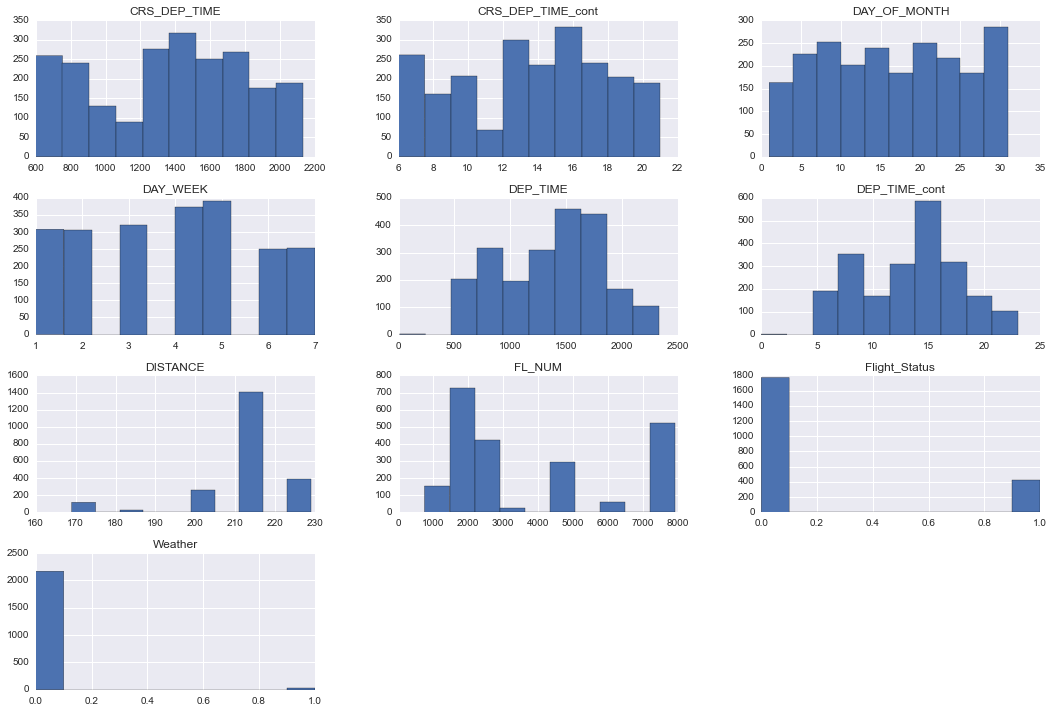

In [17]:
flights.hist(figsize=(18,12))

In [18]:
# No flights with actual departure time at midnight, 1 AM or 2 AM
# This will become a problem for fitting this cat feature

print flights.loc[(flights.dept_hours == '23')].shape[0], "flights depart at 11pm."
print flights.loc[(flights.dept_hours == '0')].shape[0], "flights depart at midnight."
print flights.loc[(flights.dept_hours == '2')].shape[0], "flights depart at 2 AM."

# But many of them depart at 4 PM
print "But", flights.loc[(flights.dept_hours == '16')].shape[0], "depart at 4 PM."

4 flights depart at 11pm.
1 flights depart at midnight.
0 flights depart at 2 AM.
But 219 depart at 4 PM.


In [19]:
print flights.loc[(flights.DEP_TIME_cont == 24)].shape
print flights.loc[(flights.DEP_TIME_cont == 3)].shape
print flights.loc[(flights.dept_hours == '02')].shape

# But many of them depart at 4 PM
print flights.loc[(flights.dept_hours == '16')].shape

(0, 22)
(0, 22)
(0, 22)
(219, 22)


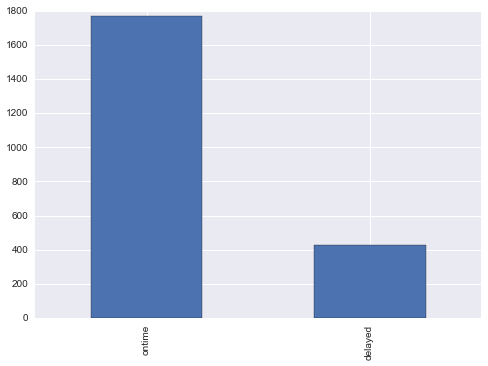

In [20]:
# ~20% of flights in the dataset were delayed.
flights['Flight Status'].value_counts().plot(kind='bar')

Flights seem to have a low probability of delay on Saturday.
We see higher percentages and numbers of delays on Monday and Sunday.


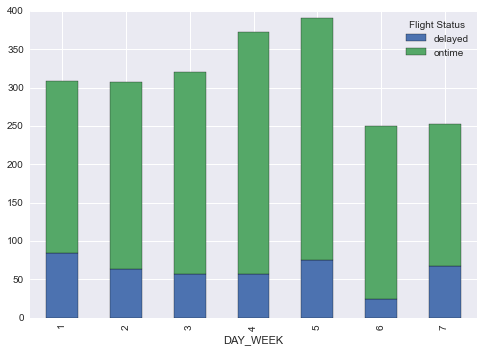

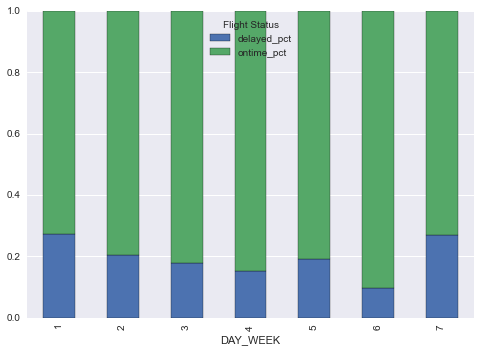

In [21]:
# This imitates the blog post
# See flight delays by day of the week
# By number and percentage

f2 = flights.groupby(['Flight Status', 'DAY_WEEK'])['DAY_WEEK'].count().unstack('Flight Status')
f2['delayed_pct'] = f2['delayed']/(f2['delayed']+ f2['ontime'])
f2['ontime_pct'] = 1-f2['delayed_pct']

f2[['delayed','ontime']].plot(kind='bar', stacked=True)
f2[['delayed_pct','ontime_pct']].plot(kind='bar', stacked=True)

print "Flights seem to have a low probability of delay on Saturday."
print "We see higher percentages and numbers of delays on Monday and Sunday."

Here we see some airports might be more associated with delays, such as EWR


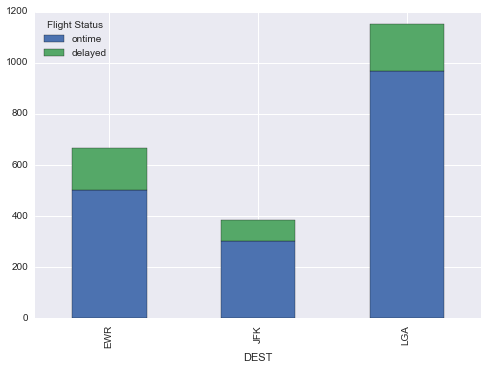

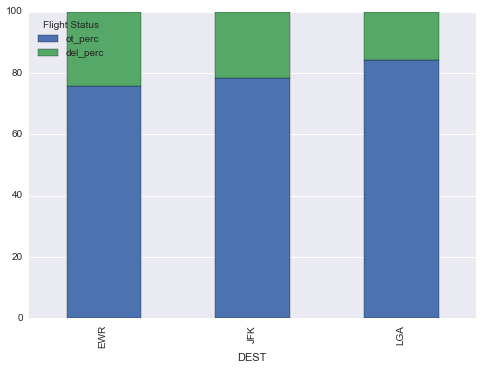

In [22]:
# Next few are from Ian
df2 = flights.groupby(['DEST', 'Flight Status'])['DEST'].count().unstack('Flight Status').fillna(0)

df2['ot_perc'] = 1.0 * df2['ontime'] / (df2['delayed'] + df2['ontime']) * 100
df2['del_perc'] = 1.0 * df2['delayed'] / (df2['delayed'] + df2['ontime']) * 100

df2[['ontime','delayed']].plot(kind='bar', stacked=True)
df2[['ot_perc','del_perc']].plot(kind='bar', stacked=True)

del df2

print "Here we see some airports might be more associated with delays, such as EWR"

Here we see some airports might be more associated with more on-time departures, such as DCA


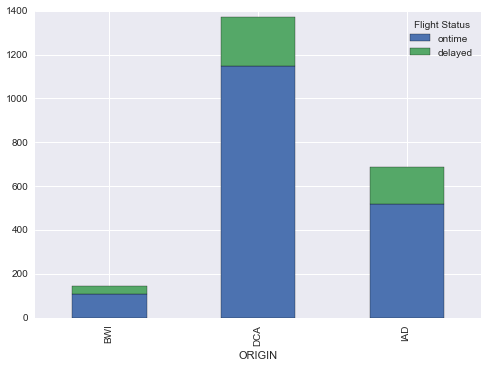

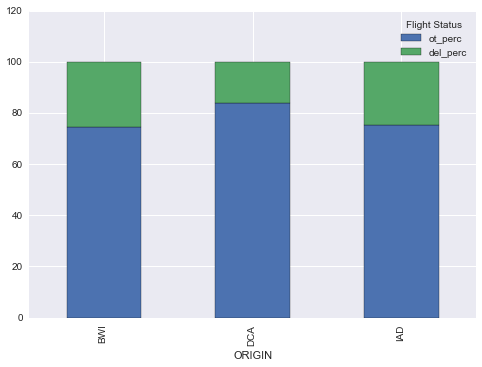

In [23]:
df2 = flights.groupby(['ORIGIN', 'Flight Status'])['DEST'].count().unstack('Flight Status').fillna(0)

df2['ot_perc'] = 1.0 * df2['ontime'] / (df2['delayed'] + df2['ontime']) * 100
df2['del_perc'] = 1.0 * df2['delayed'] / (df2['delayed'] + df2['ontime']) * 100

df2[['ontime','delayed']].plot(kind='bar', stacked=True)
df2[['ot_perc','del_perc']].plot(kind='bar', stacked=True)

del df2

print "Here we see some airports might be more associated with more on-time departures, such as DCA"

Here we see some airlines might be more associated with delays, such as CO, DH, MQ, and RU.


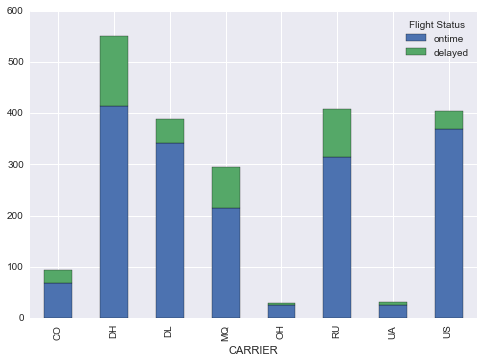

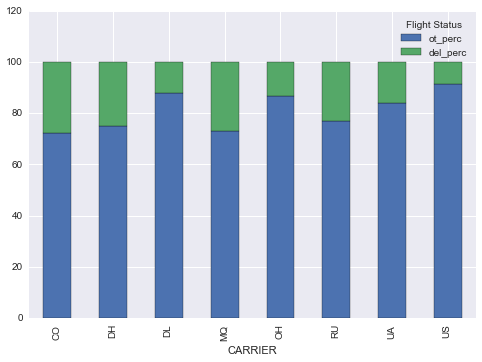

In [24]:
df2 = flights.groupby(['CARRIER', 'Flight Status'])['CARRIER'].count().unstack('Flight Status').fillna(0)

df2['ot_perc'] = 1.0 * df2['ontime'] / (df2['delayed'] + df2['ontime']) * 100
df2['del_perc'] = 1.0 * df2['delayed'] / (df2['delayed'] + df2['ontime']) * 100

df2[['ontime','delayed']].plot(kind='bar', stacked=True)
df2[['ot_perc','del_perc']].plot(kind='bar', stacked=True)

del df2
print "Here we see some airlines might be more associated with delays, such as CO, DH, MQ, and RU."

Looks like overall more flights delayed later in the day, even though overall number of flights goes down.
Also, note that delays are culmulative. If earlier flights are delayed, then the ones afterwards are likely to be affected.


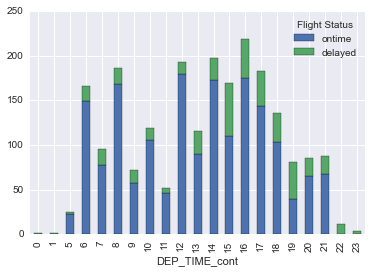

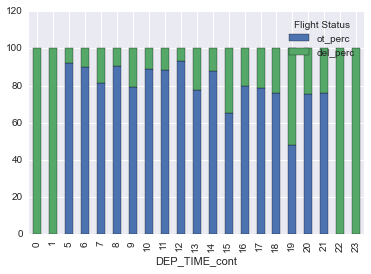

In [50]:
flights = flights.sort(['DEP_TIME_cont'], ascending=[1])

df2 = flights.groupby(['DEP_TIME_cont', 'Flight Status'])['DEP_TIME_cont'].count().unstack('Flight Status').fillna(0)

df2['ot_perc'] = 1.0 * df2['ontime'] / (df2['delayed'] + df2['ontime']) * 100
df2['del_perc'] = 1.0 * df2['delayed'] / (df2['delayed'] + df2['ontime']) * 100

df2[['ontime','delayed']].plot(kind='bar', stacked=True)
df2[['ot_perc','del_perc']].plot(kind='bar', stacked=True)

del df2
print "Looks like overall more flights delayed later in the day, even though overall number of flights goes down."
print "Also, note that delays are culmulative. If earlier flights are delayed, then the ones afterwards are likely to be affected."

See the same general trend for scheduled departure date.


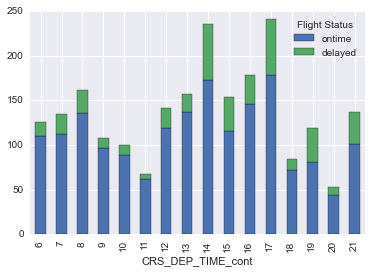

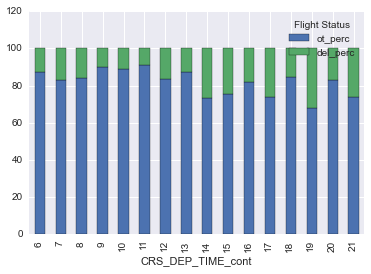

In [28]:
flights = flights.sort(['CRS_DEP_TIME_cont'], ascending=[1])

df2 = flights.groupby(['CRS_DEP_TIME_cont', 'Flight Status'])['CRS_DEP_TIME_cont'].count().unstack('Flight Status').fillna(0)

df2['ot_perc'] = 1.0 * df2['ontime'] / (df2['delayed'] + df2['ontime']) * 100
df2['del_perc'] = 1.0 * df2['delayed'] / (df2['delayed'] + df2['ontime']) * 100

df2[['ontime','delayed']].plot(kind='bar', stacked=True)
df2[['ot_perc','del_perc']].plot(kind='bar', stacked=True)

del df2
print "See the same general trend for scheduled departure date."

# Now train the model described by the blog
- Use Patsy to create the dummy vars needed
- Then split into training and test set 
    - We do this in this order to avoid have a different number of levels in test and train.
- Fit the model
    - In statsmodel
    - In scikit-learn
- Calculate score, for logistic regression it's accuracy
- Calculate AUC and draw ROC curve
- Interpret

In [254]:
## THE BLOG MODEL
## Call:
## glm(formula = FlightStatus ~ ., family = binomial, data = train)
## 
## Deviance Residuals: 
##     Min       1Q   Median       3Q      Max  
## -2.9293   0.2287   0.4632   0.6330   1.4940  
## 
## Coefficients: (1 not defined because of singularities)
##                                Estimate Std. Error z value Pr(>|z|)    
## (Intercept)                   -18.00948 2399.54481  -0.008 0.994012    
## CARRIERDH                       1.22308    0.59115   2.069 0.038549 *  
## CARRIERDL                       1.85836    0.54340   3.420 0.000627 ***
## CARRIERMQ                       0.62141    0.51715   1.202 0.229517    
## CARRIEROH                       2.21278    0.95203   2.324 0.020111 *  
## CARRIERRU                       1.05671    0.44686   2.365 0.018043 *  
## CARRIERUA                       1.59265    0.98043   1.624 0.104283    
## CARRIERUS                       2.10368    0.55575   3.785 0.000154 ***
## DESTJFK                        -0.02558    0.36198  -0.071 0.943666    
## DESTLGA                        -0.28915    0.36769  -0.786 0.431636    
## ORIGINDCA                       1.48927    0.42527   3.502 0.000462 ***
## ORIGINIAD                       0.50949    0.40285   1.265 0.205968    
## DAY_WEEK2                       0.27817    0.28915   0.962 0.336039    
## DAY_WEEK3                       0.43535    0.28308   1.538 0.124070    
## DAY_WEEK4                       0.48144    0.27512   1.750 0.080136 .  
## DAY_WEEK5                       0.43374    0.27570   1.573 0.115672    
## DAY_WEEK6                       1.28499    0.37066   3.467 0.000527 ***
## DAY_WEEK7                      -0.02538    0.28445  -0.089 0.928917    
## HourBlockDeptTimeHourBlock1          NA         NA      NA       NA    
## HourBlockDeptTimeHourBlock10   18.07704 2399.54479   0.008 0.993989    
## HourBlockDeptTimeHourBlock11   17.45879 2399.54487   0.007 0.994195    
## HourBlockDeptTimeHourBlock12   18.09730 2399.54478   0.008 0.993982    
## HourBlockDeptTimeHourBlock13   16.47483 2399.54476   0.007 0.994522    
## HourBlockDeptTimeHourBlock14   17.78484 2399.54477   0.007 0.994086    
## HourBlockDeptTimeHourBlock15   15.96003 2399.54477   0.007 0.994693    
## HourBlockDeptTimeHourBlock16   16.99874 2399.54476   0.007 0.994348    
## HourBlockDeptTimeHourBlock17   16.99070 2399.54476   0.007 0.994350    
## HourBlockDeptTimeHourBlock18   16.69408 2399.54477   0.007 0.994449    
## HourBlockDeptTimeHourBlock19   15.49419 2399.54478   0.006 0.994848    
## HourBlockDeptTimeHourBlock20   16.30981 2399.54479   0.007 0.994577    
## HourBlockDeptTimeHourBlock21   17.16271 2399.54477   0.007 0.994293    
## HourBlockDeptTimeHourBlock22   -0.95332 2538.73457   0.000 0.999700    
## HourBlockDeptTimeHourBlock23   -0.51317 2680.37215   0.000 0.999847    
## HourBlockDeptTimeHourBlock5    17.46843 2399.54490   0.007 0.994192    
## HourBlockDeptTimeHourBlock6    17.90277 2399.54478   0.007 0.994047    
## HourBlockDeptTimeHourBlock7    17.51392 2399.54479   0.007 0.994176    
## HourBlockDeptTimeHourBlock8    17.94252 2399.54478   0.007 0.994034    
## HourBlockDeptTimeHourBlock9    16.07116 2399.54479   0.007 0.994656    
## Weather                       -17.74165  493.32979  -0.036 0.971312    
## ---

In [529]:
# Use Patsy to get the variables for the model
# For both datasets
# We have to first create dummy variables
# Then split into test/train to make sure we have the same categories in both
# So unfortunately, when we compare to another model with diff vars, test set will
# be different
#dept_hours
#DEP_TIME_cont

form = 'Flight_Status ~ CARRIER+DEST+ORIGIN+DAY_of_WEEK+Weather_cat+dept_hours'
y_all, X_all = patsy.dmatrices(form, flights,return_type='dataframe')

print y_all.shape, X_all.shape

(2201, 1) (2201, 39)


In [604]:
# Test and train split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all, y_all, train_size=0.5)

print y_test.shape, X_test.shape
print y_train.shape, X_train.shape

(1101, 1) (1101, 39)
(1100, 1) (1100, 39)


In [605]:
# Train a model using statsmodel
# Doesn't converge so not sure if we should trust these coeffs
# I think this does or doesn't converge depending on training set

blog_mod = sm.Logit(y_train,X_train)
results = blog_mod.fit()
results.summary()

         Current function value: 0.392745
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Flight_Status   No. Observations:                 1100
Model:                          Logit   Df Residuals:                     1061
Method:                           MLE   Df Model:                           38
Date:                Mon, 08 Feb 2016   Pseudo R-squ.:                  0.1966
Time:                        02:44:37   Log-Likelihood:                -432.02
converged:                      False   LL-Null:                       -537.73
                                        LLR p-value:                 6.269e-26
============================================================================================
                               coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                   41.1946   2.55e+04      0.002      0.999        -5e+04  5.01e+04
CARRIER[T.DH]               -1.2642      0.684     -1.849      0.064        -2.604     0.076
CARRIER[T.DL]               -1.4267      0.627     -2.277      0.023        -2.655    -0.199
CARRIER[T.MQ]               -0.1304      0.607     -0.215      0.830        -1.320     1.059
CARRIER[T.OH]               -1.8843      1.086     -1.735      0.083        -4.013     0.244
CARRIER[T.RU]               -0.4736      0.528     -0.897      0.370        -1.509     0.562
CARRIER[T.UA]               -1.2763      1.050     -1.216      0.224        -3.334     0.782
CARRIER[T.US]               -2.4010      0.674     -3.565      0.000        -3.721    -1.081
DEST[T.JFK]                  0.3841      0.415      0.924      0.355        -0.430     1.198
DEST[T.LGA]                  0.5224      0.422      1.236      0.216        -0.306     1.350
ORIGIN[T.DCA]               -0.5603      0.482     -1.162      0.245        -1.505     0.385
ORIGIN[T.IAD]                0.4079      0.444      0.919      0.358        -0.462     1.278
DAY_of_WEEK[T.Monday]        0.3314      0.302      1.098      0.272        -0.260     0.923
DAY_of_WEEK[T.Saturday]     -0.8875      0.434     -2.043      0.041        -1.739    -0.036
DAY_of_WEEK[T.Sunday]        0.2751      0.307      0.896      0.370        -0.327     0.877
DAY_of_WEEK[T.Thursday]     -0.0287      0.288     -0.100      0.921        -0.594     0.537
DAY_of_WEEK[T.Tuesday]      -0.1293      0.316     -0.409      0.683        -0.749     0.490
DAY_of_WEEK[T.Wednesday]     0.0086      0.299      0.029      0.977        -0.578     0.595
Weather_cat[T.good]        -24.2059    2.5e+04     -0.001      0.999     -4.91e+04  4.91e+04
dept_hours[T.1]              9.0711   3.86e+05   2.35e-05      1.000     -7.56e+05  7.56e+05
dept_hours[T.10]           -18.8151   4881.161     -0.004      0.997     -9585.715  9548.084
dept_hours[T.11]           -17.2206   4881.161     -0.004      0.997     -9584.120  9549.679
dept_hours[T.12]           -18.9282   4881.161     -0.004      0.997     -9585.828  9547.971
dept_hours[T.13]           -17.6572   4881.161     -0.004      0.997     -9584.557  9549.242
dept_hours[T.14]           -17.8850   4881.161     -0.004      0.997     -9584.784  9549.014
dept_hours[T.15]           -16.9874   4881.161     -0.003      0.997     -9583.887  9549.912
dept_hours[T.16]           -17.9013   4881.161     -0.004      0.997     -9584.801  9548.998
dept_hours[T.17]           -17.1640   4881.161     -0.004      0.997     -9584.063  9549.735
dept_hours[T.18]           -17.5034   4881.161     -0.004      0.997     -9584.403  9549.396
dept_hours[T.19]           -16.0882   4881.161     -0.003      0.997     -9582.988  9550.811
dept_hours[T.20]           -16.4814   4881.161     -0.003      0.997     -9583.381  9550.418
dept_hours[T.21]           -17.8246   4881.161     -0.004      0.997     -9584.

In [606]:
# Use scikit learn to implement 
X_train1 = X_train.values
y_train1 = y_train.values.ravel()

print X_train1.shape
blog_mod_f = linear_model.LogisticRegression()
blog_mod_f.fit(X_train1, y_train1)

(1100, 39)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [607]:
# from Pat K
import pprint
pp = pprint.PrettyPrinter()

X_train_cols = list(X_train.columns.values)
print "----------------------------------"
pp.pprint(zip(X_train_cols, blog_mod_f.coef_[0]))
print "----------------------------------"
print ""
print "Positively associated with delay: MQ airline, Monday, Sunday, and Hours 1, 9, 13, 15, 16, 18, 19, 20, 22, 23."
print "Why would it make sense that later times are associated with flight delay?"

----------------------------------
[('Intercept', 0.50816564936279196),
 ('CARRIER[T.DH]', -0.23382465999501953),
 ('CARRIER[T.DL]', -0.56427307317728193),
 ('CARRIER[T.MQ]', 0.59204992015629443),
 ('CARRIER[T.OH]', -0.48352031846449656),
 ('CARRIER[T.RU]', 0.16819050880321038),
 ('CARRIER[T.UA]', -0.016131242566644811),
 ('CARRIER[T.US]', -1.3973362376781975),
 ('DEST[T.JFK]', 0.013647938065593246),
 ('DEST[T.LGA]', 0.18149264001111237),
 ('ORIGIN[T.DCA]', -0.22253569349511196),
 ('ORIGIN[T.IAD]', 0.48512429411794183),
 ('DAY_of_WEEK[T.Monday]', 0.41693986242049141),
 ('DAY_of_WEEK[T.Saturday]', -0.74799778249483118),
 ('DAY_of_WEEK[T.Sunday]', 0.26457633810938169),
 ('DAY_of_WEEK[T.Thursday]', -0.012581104237108048),
 ('DAY_of_WEEK[T.Tuesday]', -0.03849782092599565),
 ('DAY_of_WEEK[T.Wednesday]', -0.0039839589740820304),
 ('Weather_cat[T.good]', -2.3607869087615749),
 ('dept_hours[T.1]', 0.58169274883697319),
 ('dept_hours[T.10]', -0.9597468369497103),
 ('dept_hours[T.11]', 0.1705792

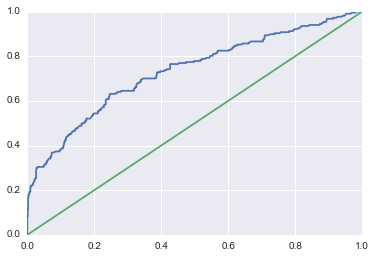

In [608]:
# Calculate AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, blog_mod_f.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,
         fpr, fpr) # Second x,y pairs here are just to plot a line with slop 1.

# This is the correct version as opposed to Lesson 7
# metrics.roc_auc_score(y_test, model.predict(X_test))
# Using that code, the ROC would be 0.5 which does not match the pictures

In [609]:
# AUC for this model
auc = metrics.roc_auc_score(y_test, blog_mod_f.predict_proba(X_test)[:,1])
print "The AUC of this model is", auc

The AUC of this model is 0.732215839189


In [610]:
# score this model
accuracy = blog_mod_f.score(X_train, y_train)
accuracy1 = blog_mod_f.score(X_test, y_test)
print "The accuracy of the blog model on the train set is", accuracy
print "The accuracy of the blog model on the test set is", accuracy1

The accuracy of the blog model on the train set is 0.839090909091
The accuracy of the blog model on the test set is 0.83378746594


In [613]:
# Try running cross-validation
# Cross validation metric here is accuracy = # correct / # total 
from sklearn import cross_validation

# Scores are mean accuracy 

model_accuracy_scores = cross_validation.cross_val_score(blog_mod_f, X_all.values, y_all.values.ravel(), cv=8)
print model_accuracy_scores
print("Accuracy: %0.2f (+/- %0.2f)" % (model_accuracy_scores.mean(), model_accuracy_scores.std() * 2))

[ 0.8115942   0.22826087  0.34782609  0.64855072  0.15272727  0.2919708
  0.27737226  0.60218978]
Accuracy: 0.42 (+/- 0.44)


In [601]:
# Turn probabilities into predictions with a 0.3 threshold
def thres(dec):
    if dec <= 0.3:
        return 0
    else: 
        return 1
    
blog_mod_f_probs = blog_mod_f.predict_proba(X_test)[:,1]
blog_mod_f_binary = map(thres, blog_mod_f_probs)

In [602]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test.values, blog_mod_f_binary)

array([[320,  34],
       [ 46,  41]])

In [603]:
print "Use these numbers to see the rows are actuals. 1st row: actual on time. 2nd row actual delayed. diagnoals are correct predictions."
print y_test["Flight_Status"].describe()
print 441*.194432, 441-441*.194432

Use these numbers to see the rows are actuals. 1st row: actual on time. 2nd row actual delayed. diagnoals are correct predictions.
count    441.000000
mean       0.197279
std        0.398397
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Flight_Status, dtype: float64
85.744512 355.255488


A few things about the blog model: 
- Having too many coefficients to estimate with not a whole lot of data (Some of those hours had very few flight departures) is a bad idea because the model might not estimate them or it might not converge. You can see how high some of those standard errors are from the blog post in his model output: http://dataillumination.blogspot.hk/2015/03/predicting-flights-delay-using.html
- Also with fitting each hour as a separate category, you lose the ability to see the effect of time over the whole day, i.e. the ordered and ordinal relationship of the data.
- Model AUC was around 0.65- 0.75, depending on train and test split. In this specific run it was 0.71.
- Performed well on the test set (0.82) but overall low accuracy on cross validation (0.42). Why such a large difference?
- Some interepretations make sense for coefficients.
- Useful model despite some pitfalls.

# Now fit a different model


In [485]:
# Use Patsy to get the variables for the model
# For both datasets
# We have to first create dummy variables
# Then split into test/train to make sure we have the same categories in both
# So unfortunately, when we compare to another model with diff vars, test set will
# be different
#dept_hours
#DEP_TIME_cont

form2 = 'Flight_Status ~ CARRIER+DEST+ORIGIN+DAY_of_WEEK+DEP_TIME_cont'
y_all2, X_all2 = patsy.dmatrices(form2, flights, return_type='dataframe')

print y_all2.shape, X_all2.shape

(2201, 1) (2201, 19)


In [497]:
# Test and train split
# Note this is a different test and train set, unfortunately.
X_train2, X_test2, y_train2, y_test2 = cross_validation.train_test_split(X_all2, y_all2, train_size=0.80)

print y_test2.shape, X_test2.shape
print y_train2.shape, X_train2.shape

(441, 1) (441, 19)
(1760, 1) (1760, 19)


In [498]:
# Train a model using statsmodel
# Doesn't converge so not sure if we should trust these coeffs
# I think this does or doesn't converge depending on training set

flights_mod = sm.Logit(y_train2,X_train2)
results2 = flights_mod.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.443559
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Flight_Status   No. Observations:                 1760
Model:                          Logit   Df Residuals:                     1741
Method:                           MLE   Df Model:                           18
Date:                Mon, 08 Feb 2016   Pseudo R-squ.:                 0.08713
Time:                        02:27:33   Log-Likelihood:                -780.66
converged:                       True   LL-Null:                       -855.17
                                        LLR p-value:                 1.154e-22
============================================================================================
                               coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                   -1.6222      0.480     -3.383      0.001        -2.562    -0.682
CARRIER[T.DH]               -0.6760      0.447     -1.511      0.131        -1.553     0.201
CARRIER[T.DL]               -0.9743      0.415     -2.349      0.019        -1.787    -0.161
CARRIER[T.MQ]               -0.0778      0.404     -0.193      0.847        -0.869     0.714
CARRIER[T.OH]               -1.6163      0.804     -2.011      0.044        -3.192    -0.041
CARRIER[T.RU]               -0.6191      0.346     -1.789      0.074        -1.297     0.059
CARRIER[T.UA]               -1.4218      0.894     -1.591      0.112        -3.173     0.330
CARRIER[T.US]               -1.5826      0.437     -3.625      0.000        -2.438    -0.727
DEST[T.JFK]                 -0.2391      0.269     -0.889      0.374        -0.766     0.288
DEST[T.LGA]                  0.0010      0.278      0.004      0.997        -0.543     0.545
ORIGIN[T.DCA]               -0.6977      0.327     -2.137      0.033        -1.338    -0.058
ORIGIN[T.IAD]               -0.2921      0.322     -0.907      0.364        -0.923     0.339
DAY_of_WEEK[T.Monday]        0.7123      0.214      3.334      0.001         0.294     1.131
DAY_of_WEEK[T.Saturday]     -0.7744      0.289     -2.675      0.007        -1.342    -0.207
DAY_of_WEEK[T.Sunday]        0.3824      0.231      1.655      0.098        -0.070     0.835
DAY_of_WEEK[T.Thursday]     -0.3176      0.227     -1.397      0.163        -0.763     0.128
DAY_of_WEEK[T.Tuesday]       0.2232      0.221      1.009      0.313        -0.210     0.657
DAY_of_WEEK[T.Wednesday]     0.0101      0.228      0.044      0.965        -0.437     0.457
DEP_TIME_cont                0.0990      0.015      6.434      0.000         0.069     0.129
============================================================================================
"""

Looking at these results, we can say: 
- Departure time is significantly affecting probability of delay. As time increase, the probability of delay increases.
- Departing on Sat and Monday significantly increase the probability of delay.
- Flying into LGA significantly increase the probability of delay.
- We didn't include weather because there aren't that many bad weather observations and so sometimes the model wouldn't converge.

In [508]:
# Confusion matrix for training set
results2.pred_table(threshold=0.25)

array([[ 1127.,   299.],
       [  162.,   172.]])

In [509]:
# Use scikit learn to implement 
X_train3 = X_train2.values
y_train3 = y_train2.values.ravel()

print X_train2.shape
flight_mod2 = linear_model.LogisticRegression()
flight_mod2.fit(X_train3, y_train3)

(1760, 19)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [510]:
# from Pat K
import pprint
pp = pprint.PrettyPrinter()

X_train_cols2 = list(X_train2.columns.values)
print "----------------------------------"
pp.pprint(zip(X_train_cols2, flight_mod2.coef_[0]))
print "----------------------------------"
print ""

----------------------------------
[('Intercept', -0.94275162171252513),
 ('CARRIER[T.DH]', -0.26386563705440064),
 ('CARRIER[T.DL]', -0.58572322568801272),
 ('CARRIER[T.MQ]', 0.27608011379397518),
 ('CARRIER[T.OH]', -0.84413855079953404),
 ('CARRIER[T.RU]', -0.34654937745554787),
 ('CARRIER[T.UA]', -0.63991467099122257),
 ('CARRIER[T.US]', -1.1583905601253808),
 ('DEST[T.JFK]', -0.38681862999935918),
 ('DEST[T.LGA]', -0.18175821363373629),
 ('ORIGIN[T.DCA]', -0.56631794908427968),
 ('ORIGIN[T.IAD]', -0.27001043061037394),
 ('DAY_of_WEEK[T.Monday]', 0.66332655859410683),
 ('DAY_of_WEEK[T.Saturday]', -0.765088657113562),
 ('DAY_of_WEEK[T.Sunday]', 0.34750136493716033),
 ('DAY_of_WEEK[T.Thursday]', -0.33110026233304812),
 ('DAY_of_WEEK[T.Tuesday]', 0.19222523334446079),
 ('DAY_of_WEEK[T.Wednesday]', -0.015469635333160035),
 ('DEP_TIME_cont', 0.096620998719989387)]
----------------------------------



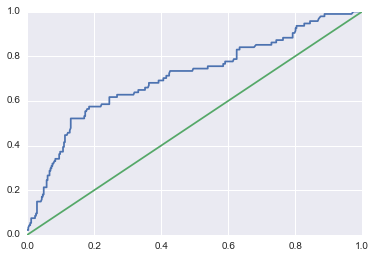

In [511]:
# Calculate AUC
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test2, flight_mod2.predict_proba(X_test2)[:,1])

plt.plot(fpr2, tpr2,
         fpr2, fpr2) # Second x,y pairs here are just to plot a line with slop 1.

# This is the correct version as opposed to Lesson 7
# metrics.roc_auc_score(y_test, model.predict(X_test))
# Using that code, the ROC would be 0.5 which does not match the pictures

In [512]:
# AUC for this model
auc2 = metrics.roc_auc_score(y_test2, flight_mod2.predict_proba(X_test2)[:,1])
print "The AUC of this model is", auc2

The AUC of this model is 0.709638849715


In [513]:
# score this model
accuracy_train = flight_mod2.score(X_train2, y_train2)
accuracy_test = flight_mod2.score(X_test2, y_test2)
print "The accuracy of the blog model on the train set is", accuracy_train
print "The accuracy of the blog model on the test set is", accuracy_test

The accuracy of the blog model on the train set is 0.813068181818
The accuracy of the blog model on the test set is 0.791383219955


In [514]:
# Try running cross-validation
# Cross validation metric here is accuracy = # correct / # total 
# Scores are mean accuracy 

model_accuracy_scores2 = cross_validation.cross_val_score(flight_mod2, X_all2.values, y_all2.values.ravel(), cv=8)
print model_accuracy_scores2
print("Accuracy: %0.2f (+/- %0.2f)" % (model_accuracy_scores2.mean(), model_accuracy_scores2.std() * 2))

[ 0.80434783  0.80434783  0.80434783  0.80434783  0.80727273  0.80656934
  0.82116788  0.77372263]
Accuracy: 0.80 (+/- 0.02)


In [515]:
# Turn probabilities into predictions with a 0.3 threshold
def thres(dec):
    if dec <= 0.3:
        return 0
    else: 
        return 1
    
flight_mod2_probs = flight_mod2.predict_proba(X_test2)[:,1]
flight_mod2_binary = map(thres, flight_mod2_probs)

In [516]:
confusion_matrix(y_test2.values, flight_mod2_binary)

array([[302,  45],
       [ 46,  48]])

Compare with previous model: 
array([[340,  49],
       [ 59,  37]])

Overall, flight_mod2 and blog_mod_f have a similar performance on the test set of ~.80 accuacy and of ~.70. However, we did see differences in k-fold cross validation. The blog model had accuracy of 0.42 while the second model had accuracy of 0.80. Perhaps the first model doesn't train well on smaller datasets because of the number of coefficients it needs to predict.